<a href="https://colab.research.google.com/github/kraken114/Colab/blob/main/3D_Deep_learning_4_%D1%81%D1%82%D1%80_110_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_2D_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%B0_%D0%BF%D0%BE_%D1%84%D0%BE%D1%82%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ГЛАВА 5**

# **Понятие дифференцируемой объемометрической отрисовки**

# **(типа создание 3D объекта по фото с нескольких ракурсов)**

**MonteCarloRaysampler** - отборщик лучей, используется для обучения, т.к. делает репрезезентативную выборку луче(т.е отбирае часть лучей).

**NDCMultiNomialRaysampler** - лучевой отборщик, выбирает все пикселы,используется для отрисовки и визуализации

**NDCGridRaysampler** - похож на лучевой отборщик NDCMultiNomial-
Raysampler, в котором пикселы отбираются вдоль решетки



---



---



---



---



---



---



# **Это необходимо для использования графики в Colab**

**1. Вначале необходимо импортировать все требующиеся модули Python:**

In [ ]:
%%capture
# блок установки pytorch3d
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
%%capture
!pip install open3d
!wget https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj
import numpy as np
import plotly.graph_objects as go
import open3d as o3d
from pytorch3d.io import load_ply
import matplotlib.pyplot as plt

!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# https://linkhs.github.io/Colab/Open3D/Open3D_visualization.html
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()
# draw_geometries('/content/cube.ply')

# **Конец необхдимого**



---



---



---



---



---



---



In [ ]:
# 1. Сначала необходимо импортировать все модули Python, включая опре-
# деление лучевого отборщика NDCGridRaysampler:

import torch
import math
import numpy as np

from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    PointLights,
    look_at_view_transform,
    NDCGridRaysampler,
)

# **Понятие отбора лучей**

In [ ]:
# 2. Настраиваем устройство для использования в следующих далее шагах.
# Если у вас имеются графические процессоры, то будем использовать
# первый графический процессор. В противном случае будем использо-
# вать центральный процессор:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [ ]:
# 3. Определяем пакет из 10 камер. Здесь num_views – это число ракурсов,
# в данном случае 10. Переменная elev обозначает угол возвышения,
# а azim – угол азимута. Указанные переменные позволяют определить
# поворот R и трансляцию T с помощью функции PyTorch3D look_at_
# view_transform. Тогда 10 камер можно определить, используя повороты
# и трансляции. Все 10 камер направлены на объект, расположенный
# в центре мировых координат:

num_views: int = 10
azimuth_range: float = 180
elev = torch.linspace(0, 0, num_views)  # tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
azim = torch.linspace(-azimuth_range, azimuth_range, num_views) + 180.0
# tensor([  0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360.])
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
# R == torch.Size([10, 3, 3]) - поворот
# T == torch.Size([10, 3]) - трансляция
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

In [ ]:
print(R)

In [ ]:
print(T)

In [ ]:
# 4. Наконец, можно определить лучевой отборщик, т. е. переменную raysampler.
# Далее, нужно указать размер изображения в камере. Кроме
# того, требуется указать минимальную и максимальную глубины, в ко-
# торых луч колеблется. Входной параметр n_pts_per_ray – это число то-
# чек вдоль луча:

image_size = 64
volume_extent_world = 3.0
raysampler = NDCGridRaysampler(
    image_width=image_size,
    image_height=image_size,
    n_pts_per_ray=50,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

In [ ]:
# 5. На предыдущем шаге мы уже определили лучевой отборщик. Для того
# чтобы лучевой отборщик делал выборку вдоль луча подлежащих ис-
# пользованию точек, необходимо ему сообщить, где находятся камеры
# и в каком направлении они указывают. Этого делается легко путем
# передачи в raysampler камер, определенных на шаге 3. На выходе мы
# получаем переменную ray_bundle (пучек лучей):

ray_bundle = raysampler(cameras)

**ray_bundle** - лучевой отборщик и указанными камерами

In [ ]:
# 6. Переменная ray_bundle содержит коллекцию разных тензоров PyTorch,
# которые определяют отобранные лучи и точки. Эти переменные можно
# распечатать, чтобы проверить их очертание и содержимое:

print('Очертание тензора источников в ray_bundle = ',
ray_bundle.origins.shape)
print('Очертание тензора направлений в ray_bundle = ',
ray_bundle.directions.shape)
print('Очертание тензора длин в ray_bundle = ',
ray_bundle.lengths.shape)
print('Очертание тензора xy-местоположений в ray_bundle = ',
ray_bundle.xys.shape)

Очертание тензора источников в ray_bundle =  torch.Size([10, 64, 64, 3])
Очертание тензора направлений в ray_bundle =  torch.Size([10, 64, 64, 3])
Очертание тензора длин в ray_bundle =  torch.Size([10, 64, 64, 50])
Очертание тензора xy-местоположений в ray_bundle =  torch.Size([10, 64, 64, 2])


In [ ]:
# 7. Исходный код должен отработать и вывести следующую ниже инфор-
# мацию.
# • Мы видим, что ray_bundle.origins – это тензор источников лучей,
# и размер пакета равен 10. Поскольку размер изображения равен
# 64×64, размер второй и третьей размерностей равен 64. У каждого
# источника должно быть три числа, чтобы указывать его 3D-местоположение.
# • ray_bundle.directions – это тензор направлений луча. Опять же, раз-
# мер пакета равен 10, и размер изображения – 64×64. Они объясняют
# размер первых трех размерностей тензора. Должно быть три числа,
# чтобы указывать направление в 3D-пространстве.
# • ray_bundle.lengths – это тензор глубины каждой точки на лучах. Это
# лучи 10×64×64, и на каждом луче 50 точек.
# • ray_bundle.xys – это тензор местоположений x и y на плоскости изо-
# бражения, соответствующей каждому лучу. Это лучи 10×64×64. Долж-
# но быть одно число для представления местоположения x и одно
# число для представления местоположения y:

In [ ]:
# 8. Наконец, сохраняем ray_bundle в PT-файл ray_sampling.pt. Эти лучи при-
# годятся в примерах программирования в следующих разделах:

torch.save({'ray_bundle': ray_bundle}, 'ray_sampling.pt')

# **Применение отбора объемов**

In [ ]:
# 1. Импортируем нужные модули Python:
import torch
from pytorch3d.structures import Volumes
from pytorch3d.renderer.implicit.renderer import VolumeSampler

In [ ]:
# 2. Настраиваем устройство:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  torch.cuda.set_device(device)
else:
  device = torch.device("cpu")

In [ ]:
# 3. Загружаем вычисленный в предыдущем разделе ray_bundle:
checkpoint = torch.load('ray_sampling.pt')
ray_bundle = checkpoint.get('ray_bundle')

In [ ]:
# 4. Затем определяем объем. Тензор плотностей имеет очертание [10, 1,
# 64, 64, 50], в котором имеется пакет из 10 объемов, и каждый объем
# представляет собой решетку из 64×64×50 узлов. Каждый узел имеет
# одно число, которое представляет плотность в узле. С другой стороны,
# тензор значений цвета имеет очертание [10, 3, 64, 64, 50], потому что
# для представления RGB-значений каждому цвету требуется три числа:

batch_size = 10
densities = torch.zeros([batch_size, 1, 64, 64, 64]).to(device)
# densities - типа батч с указанием плотности
colors = torch.zeros(batch_size, 3, 64, 64, 64).to(device)
# colors - типа батч с указанием цвета
voxel_size = 0.1

volumes = Volumes(
    densities=densities,
    features=colors,
    voxel_size=voxel_size
)

In [ ]:
# 5. Теперь необходимо определить отборщик volume_sampler на основе объ-
# емов. Здесь для отбора объемов используется билинейная интерполя-
# ция. Затем плотности и значения цвета точек на лучах можно легко
# получить, передав пучок лучей ray_bundle в отборщик volume_sampler:

volume_sampler = VolumeSampler(volumes = volumes, sample_mode = "bilinear")
rays_densities, rays_features = volume_sampler(ray_bundle)

In [ ]:
# 6. Распечатаем очертание плотностей и значений цвета:

print('rays_densities shape = ', rays_densities.shape)
print('rays_features shape = ', rays_features.shape)

rays_densities shape =  torch.Size([10, 64, 64, 50, 1])
rays_features shape =  torch.Size([10, 64, 64, 50, 3])


In [ ]:
# 8. Наконец, давайте сохраним плотности и цвета, потому что они потре-
# буются в следующем разделе:

torch.save({
    'rays_densities': rays_densities,
    'rays_features': rays_features}, 'volume_sampling.pt')

In [ ]:
# Теперь у вас есть четкое понимание отбора объемов. Вы знаете, что это
# такое и в чем его польза. В следующем разделе вы научитесь применять
# эти плотности и цвета, чтобы генерировать значения RGB-изображения для
# группы камер.

# **Обследование лучевого маршировщика**

In [ ]:
# В этом разделе мы обсудим процесс конвертирования плотностей и значе-
# ний цвета в точках лучей в RGB-значения на изображениях. Этот процесс
# моделирует физический процесс формирования изображения.

In [ ]:
# Библиотека PyTorch3D содержит несколько реализаций лучевых марши-
# ровщиков.

In [ ]:
# 1. На первом шаге импортируем все необходимые пакеты:

import torch
from pytorch3d.renderer.implicit.raymarching import EmissionAbsorptionRaymarcher

In [ ]:
# 2. Далее загружаем плотности и значения цвета на лучах из последнего
# раздела:

checkpoint = torch.load('volume_sampling.pt')
rays_densities = checkpoint.get('rays_densities')
rays_features = checkpoint.get('rays_features')

In [ ]:
# 3. Определяем лучевого маршировщика ray_marcher и передаем плотно-
# сти и цвета лучей в ray_marcher. В результате получаем признаки изо-
# бражения image_features, т. е. точно отрисованные RGB-значения:

ray_marcher = EmissionAbsorptionRaymarcher()
image_features = ray_marcher(rays_densities=rays_densities,
                              rays_features=rays_features)

In [ ]:
# 4. Распечатываем очертание признаков изображения:

print('Очертание image_features = ', image_features.shape)

Очертание image_features =  torch.Size([10, 64, 64, 4])


In [ ]:
# 5. Как и ожидалось, очертание имеет вид [10, 64, 64, 4], где 10 – это раз-
# мер пакета, а 64 – ширина и высота изображения. Выходы имеют четыре
# канала, первые три – это RGB. Последний – это альфа-канал, который
# представляет местоположение пиксела: на переднем либо заднем плане:

# **Дифференцируемая объемометрическая отрисовка**

# **Реконструкция 3D-моделей по многоракурсным изображениям**

In [ ]:
# 1. Сначала необходимо импортировать все модули Python:

import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from pytorch3d.structures import Volumes
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    VolumeRenderer,
    NDCGridRaysampler,
    EmissionAbsorptionRaymarcher
)
from pytorch3d.transforms import so3_exp_map


# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
# from plot_image_grid import image_grid
# from generate_cow_renders import generate_cow_renders

In [ ]:
# 2. Далее настраиваем устройство:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [ ]:
# 3. Используя функцию из практического руководства по PyTorch3D, мы
# создаем 40 камер, изображения и силуэтные изображения под разны-
# ми углами. Мы будем рассматривать эти изображения как заданные
# достоверные изображения и выполним подгонку трехмерной объемо-
# метрической модели к этим наблюдаемым достоверным изображени-
# ям:

target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40)

In [ ]:
target_images.shape, target_silhouettes.shape

(torch.Size([40, 128, 128, 3]), torch.Size([40, 128, 128]))

In [ ]:
# 4. Далее определяем отборщик лучей. Как отмечалось в предыдущих раз-
# делах, отборщик лучей предназначен для отбора лучей и точек на каж-
# дом луче:

render_size = 128
volume_extent_world = 3.0

raysampler = NDCGridRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=150,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

In [ ]:
# 5. Далее создаем лучевого маршировщика, как и раньше. Обратите вни-
# мание, на этот раз мы определяем переменную renderer типа VolumeRenderer.
# Класс VolumeRenderer – это просто удобный интерфейс, в котором
# отборщики лучей и лучевые маршировщики выполняют под капотом
# всю тяжелую работу:

raymarcher = EmissionAbsorptionRaymarcher()
renderer = VolumeRenderer(
    raysampler=raysampler, raymarcher=raymarcher,
)

In [ ]:
# 6. Затем определяем класс VolumeModel. Этот класс предназначен толь-
# ко для инкапсуляции объема, чтобы иметь возможность вычислять
# градиенты в функции forward, а плотности и цвета объема обновлять
# оптимизатором:

class VolumeModel(torch.nn.Module):
    def __init__(self, renderer, volume_size=[64] * 3, voxel_size=0.1):
        super().__init__()
        self.log_densities = torch.nn.Parameter(-4.0 * torch.ones(1, *volume_size))
        self.log_colors = torch.nn.Parameter(torch.zeros(3, *volume_size))
        self._voxel_size = voxel_size
        self._renderer = renderer

    def forward(self, cameras):
        batch_size = cameras.R.shape[0]

        densities = torch.sigmoid(self.log_densities)
        colors = torch.sigmoid(self.log_colors)

        volumes = Volumes(
            densities=densities[None].expand(
                batch_size, *self.log_densities.shape),
            features=colors[None].expand(
                batch_size, *self.log_colors.shape),
            voxel_size=self._voxel_size,
        )
        return self._renderer(cameras=cameras, volumes=volumes)[0]

In [ ]:
# 7. Определяем функцию потери Хьюбера. Функция потери Хьюбера – это
# устойчивая функция потери, не дающая малому числу выбросов оттягивать
# оптимизацию от истинных оптимальных решений. Минимизация этой функции
# потери приближает x к y:

def huber(x, y, scaling=0.1):
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling ** 2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

In [ ]:
# 8. Перемещаем все на нужное устройство:

target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

In [ ]:
# 9. Определяем экземпляр класса VolumeModel:

volume_size = 128
volume_model = VolumeModel(
    renderer,
    volume_size=[volume_size] * 3,
    voxel_size=volume_extent_world / volume_size,
).to(device)

In [ ]:
# 10. Теперь настраиваем оптимизатор. Значение скорости обучения lr уста-
# новлено равным 0.1. Мы используем оптимизатор Adam, и число ите-
# раций оптимизации будет равно 300:

lr = 0.1
optimizer = torch.optim.Adam(volume_model.parameters(), lr=lr)

batch_size = 10
n_iter = 300

In [ ]:
for iteration in range(n_iter):

    if iteration == round(n_iter * 0.75):
        print('Уменьшаем LR в 10 раз ...')
        optimizer = torch.optim.Adam(
            volume_model.parameters(), lr=lr * 0.1
        )

    optimizer.zero_grad()
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Произвести выборку мини-пакета камер.
    batch_cameras = FoVPerspectiveCameras(
        R=target_cameras.R[batch_idx],
        T=target_cameras.T[batch_idx],
        znear=target_cameras.znear[batch_idx],
        zfar=target_cameras.zfar[batch_idx],
        aspect_ratio=target_cameras.aspect_ratio[batch_idx],
        fov=target_cameras.fov[batch_idx],
        device=device,
    )

    rendered_images, rendered_silhouettes = volume_model(
        batch_cameras
    ).split([3, 1], dim=-1)

    sil_err = huber(
        rendered_silhouettes[..., 0], target_silhouettes[batch_idx],
    ).abs().mean()

    color_err = huber(
        rendered_images, target_images[batch_idx],
    ).abs().mean()

    loss = color_err + sil_err
    if iteration % 10 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' color_err = {float(color_err):1.2e}'
            + f' mask_err = {float(sil_err):1.2e}'
        )

    # Сделать шаг оптимизации.
    loss.backward()
    optimizer.step()

Iteration 00000: color_err = 2.67e-01 mask_err = 5.65e-01
Iteration 00010: color_err = 1.07e-01 mask_err = 3.58e-01
Iteration 00020: color_err = 3.38e-02 mask_err = 1.70e-01
Iteration 00030: color_err = 1.50e-02 mask_err = 7.79e-02
Iteration 00040: color_err = 9.14e-03 mask_err = 4.51e-02
Iteration 00050: color_err = 7.58e-03 mask_err = 2.99e-02
Iteration 00060: color_err = 5.73e-03 mask_err = 2.32e-02
Iteration 00070: color_err = 5.77e-03 mask_err = 2.12e-02
Iteration 00080: color_err = 5.43e-03 mask_err = 1.85e-02
Iteration 00090: color_err = 5.00e-03 mask_err = 1.54e-02
Iteration 00100: color_err = 5.12e-03 mask_err = 1.55e-02
Iteration 00110: color_err = 5.05e-03 mask_err = 1.44e-02
Iteration 00120: color_err = 4.63e-03 mask_err = 1.31e-02
Iteration 00130: color_err = 4.62e-03 mask_err = 1.20e-02
Iteration 00140: color_err = 4.60e-03 mask_err = 1.28e-02
Iteration 00150: color_err = 4.47e-03 mask_err = 1.25e-02
Iteration 00160: color_err = 4.13e-03 mask_err = 1.15e-02
Iteration 0017

In [ ]:
# генерировать вращающийся объем

def generate_rotating_volume(volume_model, n_frames=50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(0.0, 2.0 * 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Generating rotating volume ...')
    for R, T in zip(Rs, Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear=target_cameras.znear[0],
            zfar=target_cameras.zfar[0],
            aspect_ratio=target_cameras.aspect_ratio[0],
            fov=target_cameras.fov[0],
            device=device,
        )
        frames.append(volume_model(camera)[..., :3].clamp(0.0, 1.0))
    return torch.cat(frames)

Generating rotating volume ...


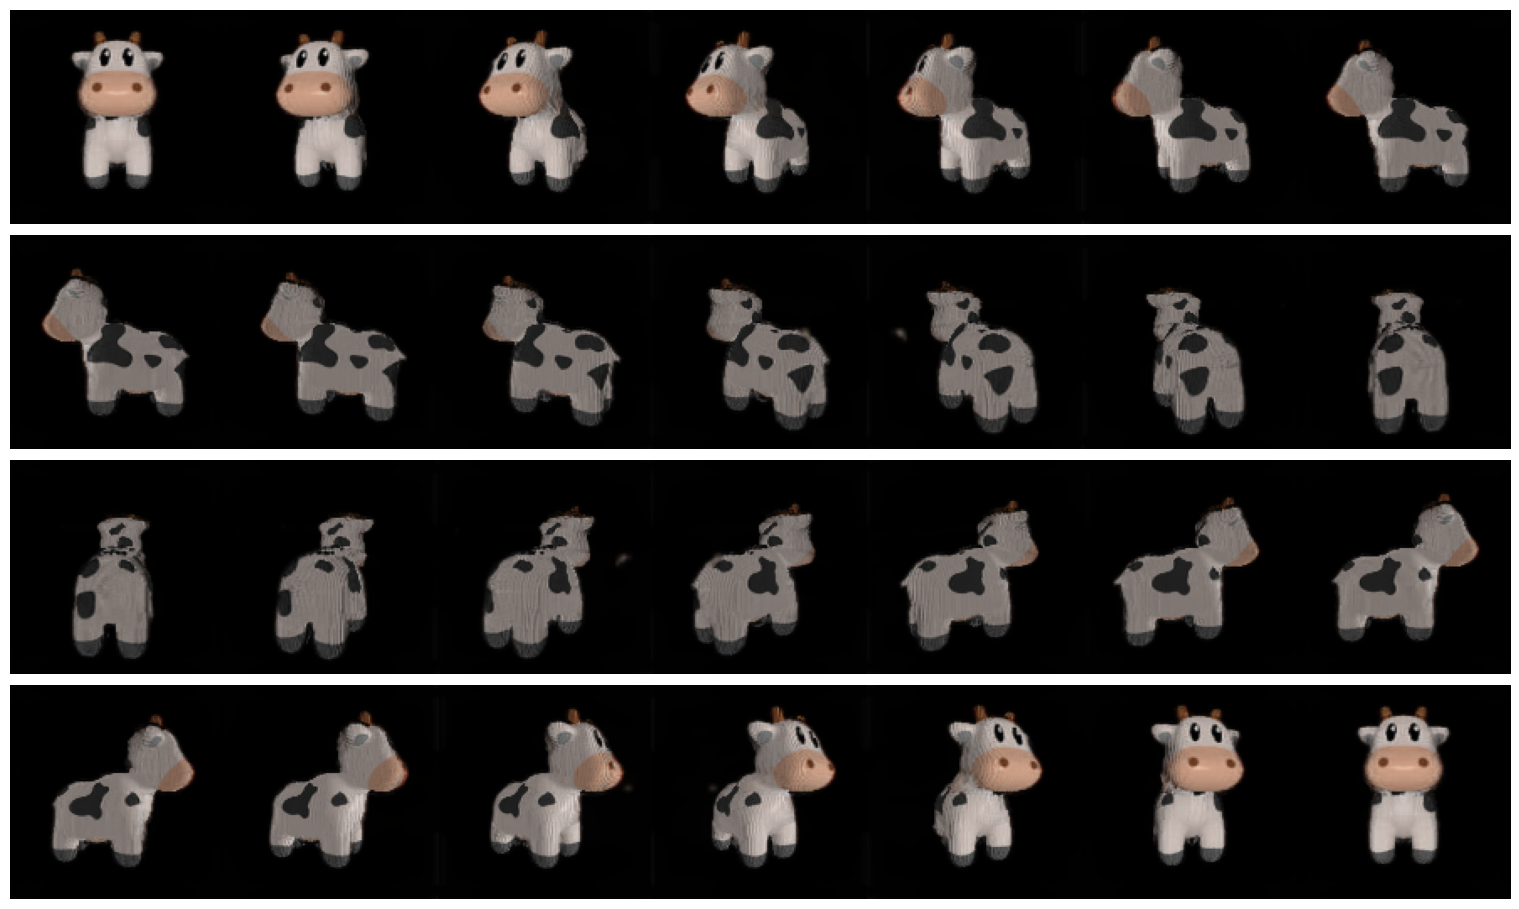

In [ ]:
# 12. После завершения оптимизации берем итоговую результирующую
# объемометрическую модель и отрисовываем изображения под новыми
# углами:

with torch.no_grad():
    rotating_volume_frames = generate_rotating_volume(volume_model, n_frames=7 * 4)

image_grid(rotating_volume_frames.clamp(0., 1.).cpu().numpy(), rows=4, cols=7, rgb=True, fill=True)
plt.savefig('rotating_volume.png')
plt.show()